## Objective:  plotting the standard deviation of the ensemble spread 

* use that perspective trend archive
* compute the standard deviation of the trends and plot that. 

This answers the question: what regions are most variable? 


In [15]:
%matplotlib inline
import os
import shutil

from itertools import product
import xpersist as xp
from glob import glob

import numpy as np
import xarray as xr

import pop_tools
import intake

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean

import util

In [16]:
ds_prosp = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf-prospective-trends.zarr')
ds_prosp

<xarray.Dataset>
Dimensions:       (length: 3, member_id: 34, nlat: 93, nlon: 320, trend_length: 4, trend_year: 2)
Coordinates:
    KMT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * length        (length) float64 20.0 40.0 60.0
  * member_id     (member_id) int64 1 2 9 10 11 12 13 ... 35 101 102 103 104 105
  * trend_length  (trend_length) int64 5 10 20 50
  * trend_year    (trend_year) int64 2006 2020
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf      (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>
    IFRAC         (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>
    KGP           (trend_length, trend_year, length, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 3, 1, 93, 320), meta=np.ndarray>
    SST           (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>

In [17]:
kgptrend_20_10 = ds_prosp['KGP'].sel(trend_length = 10, trend_year = 2020, length = 40. )
kgptrend_20_20 = ds_prosp['KGP'].sel(trend_length = 20, trend_year = 2020, length = 40. )
kgptrend_20_50 = ds_prosp['KGP'].sel(trend_length = 50, trend_year = 2020, length = 40. )

kgptrend_06_10 = ds_prosp['KGP'].sel(trend_length = 10, trend_year = 2006, length = 40. )
kgptrend_06_20 = ds_prosp['KGP'].sel(trend_length = 20, trend_year = 2006, length = 40. )
kgptrend_06_50 = ds_prosp['KGP'].sel(trend_length = 50, trend_year = 2006, length = 40. )


ssttrend_20_10 = ds_prosp['SST'].sel(trend_length = 10, trend_year = 2020 )
ssttrend_20_20 = ds_prosp['SST'].sel(trend_length = 20, trend_year = 2020 )
ssttrend_20_50 = ds_prosp['SST'].sel(trend_length = 50, trend_year = 2020 )

chltrend_20_10 = ds_prosp['Chl_surf'].sel(trend_length = 10, trend_year = 2020 )
chltrend_20_20 = ds_prosp['Chl_surf'].sel(trend_length = 20, trend_year = 2020 )
chltrend_20_50 = ds_prosp['Chl_surf'].sel(trend_length = 50, trend_year = 2020 )

### Single out a trend to plot:

In [87]:
trend_choice = chltrend_20_50

In [88]:
# Variance across members
variance = trend_choice.var('member_id')

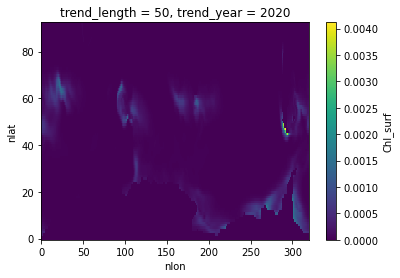

In [89]:
variance.plot()

In [90]:
# Standard deviation
standard_dev = trend_choice.std('member_id')

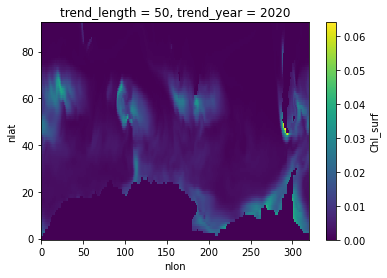

In [91]:
standard_dev.plot()

### Propper Plotting

In [92]:
# Lat Lon Checks
lon = ds_prosp.TLONG.values
lat = ds_prosp.TLAT.values

In [93]:
#POP Grid Friendly

var_to_plot = standard_dev

dsp = util.pop_add_cyclic(
    xr.Dataset({
        'test': var_to_plot,
        'TLAT': var_to_plot.TLAT.compute(),
        'TLONG': var_to_plot.TLONG.compute()
    } ))


### Formatting

In [94]:
class MidpointNormalize(colors.Normalize):
    """
    class to help renormalize the color scale
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [95]:
## KGP Settings:

extent = ([-180, 180, -90, -50], ccrs.PlateCarree()) #[120, 260, 10, 65]

prj = ccrs.SouthPolarStereo()
norm = MidpointNormalize(midpoint=0.)

## SST Settings:


## CHL Settings
#from matplotlib.colors import LogNorm
#norm = LogNorm()
#levels=[0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 1.4, 1.8, 2]


In [96]:
def one_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG,
                     dsp.TLAT,
                     da,
                     #levels=levels,
                     #norm=norm,
                     #cmap=cmocean.cm.curl_r,
                     cmap=cmocean.cm.speed,
                     #cmap=cmocean.cm.balance,
                     #cmap=cmocean.cm.diff,
                     #cmap=cmocean.cm.algae,
                     #extend='both',
                     transform=ccrs.PlateCarree())

    # contour lines
    cs = ax.contour(dsp.TLONG,
                    dsp.TLAT,
                    da,
                    colors='k',
                    #levels=levels,
                    linewidths=0.5,
                    transform=ccrs.PlateCarree())

    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r')

    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical',
                                            'land',
                                            '110m',
                                            facecolor='lightgray'))

    ax.coastlines(linewidth=0.5)

    return cf


## Plot:

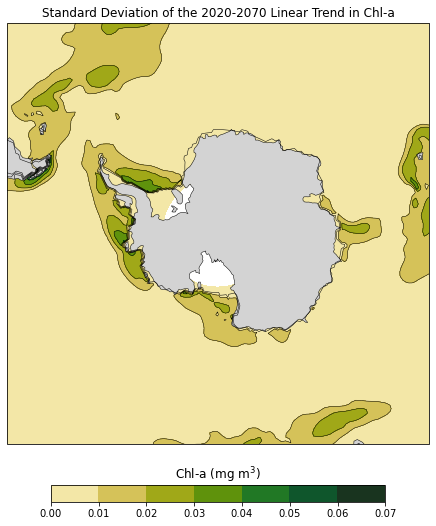

In [97]:
fig = plt.figure(figsize=(12, 10))

axs = []

# plot total
ax = fig.add_subplot(1, 1, 1, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = one_plot(dsp.test,lines = False)
ax.set_title('Standard Deviation of the 2020-2070 Linear Trend in Chl-a')
axs.append(ax)

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal', pad=0.075, ax=axs)
cb.ax.set_title('Chl-a (mg m$^3$)')

#cb.ax.set_title('Growth Potential (mm day$^{-1}$)')
plt.savefig('figures/STD-2006-50yr-CHL.png')#, dpi=300, bbox_inches='tight')
